<a href="https://colab.research.google.com/gist/KhawajaMuddassar/f4f5fce13a5ac3a46c4c3f0e02239ffe/layoutlmv3-document-ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**LayoutLMv3 (Document Foundation Model)**

**LayoutLMv3** is pre-train multimodal Transformers for Document AI with unified text and image masking. Additionally, LayoutLMv3 is pre-trained with a word-patch alignment objective to learn cross-modal alignment by predicting whether the corresponding image patch of a text word is masked. The simple unified architecture and training objectives make LayoutLMv3 a general-purpose pre-trained model for both text-centric and image-centric Document AI tasks including form understanding, receipt understanding, document visual question answering, and also in image-centric tasks such as document image classification and document layout analysis.

Below figure gives a good overview of the model (from the original paper):

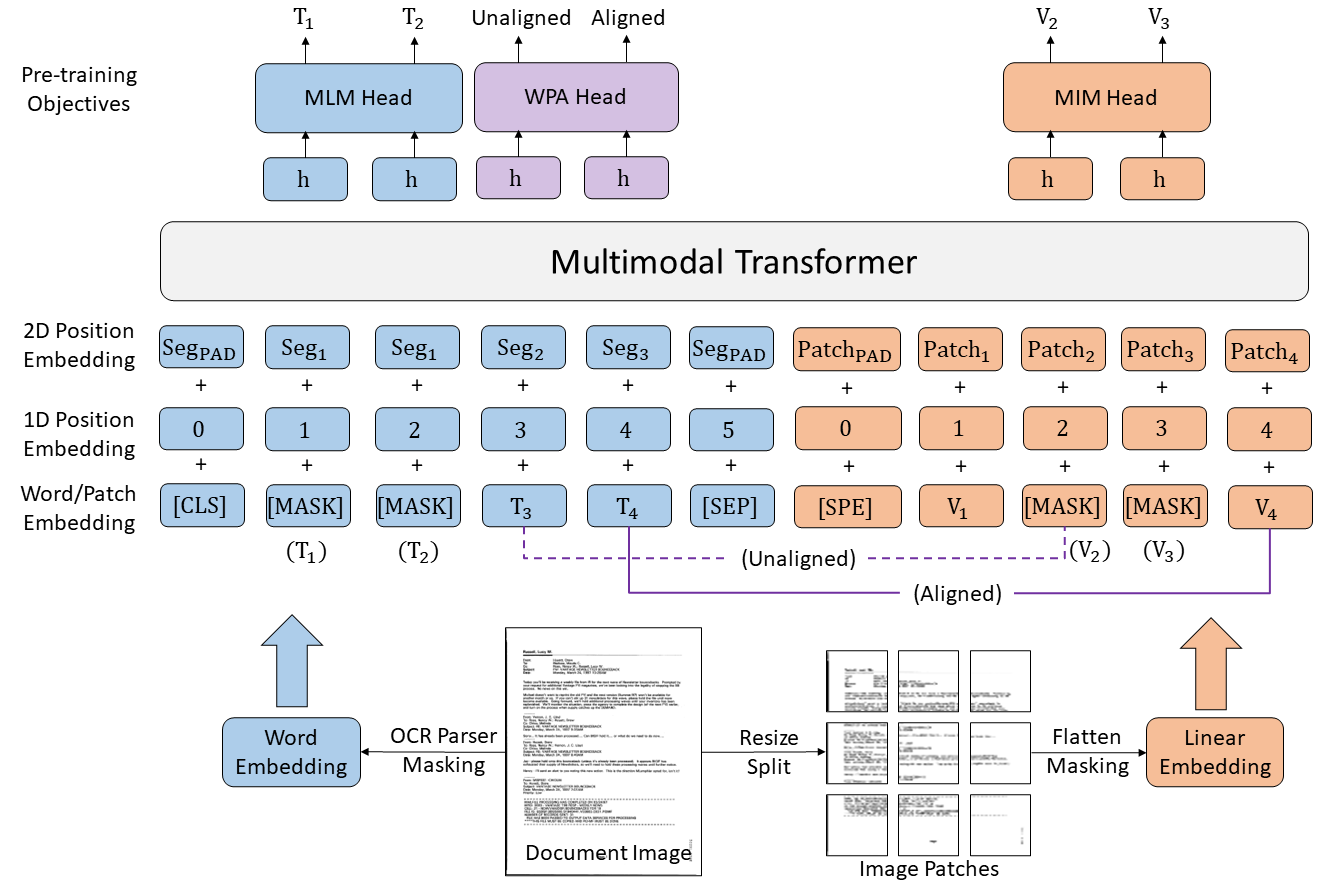

* LayoutLMv3 Paper: https://arxiv.org/pdf/2204.08387


The above architecture workflow is as follows:
1. Words are obtained from an image using a typical OCR parser
2. The words are then converted into embeddings using the RoBERTa model [more details](https://arxiv.org/pdf/1907.11692)
3. The document is resized into a fixed shape and then converted into multiple patches
4. Each patch is flattened and passed through a linear layer to obtain embeddings corresponding to the patch
5. The 1D position embeddings correspond to the index of the word/patch while the 2D position embeddings correspond to the bounding box/segment
6. Once the embeddings are in place, we perform masked pre-training (MLM Head) in a manner similar to that of LayoutLM, where we mask certain words and predict them using the context. Similarly in masked image modeling (MIM Head), we mask certain blocks and predict the tokens within the block
7. Word patch alignment (WPA Head) is then performed, which refers to the task of predicting whether a masked image patch has the corresponding tokens masked. If a token is masked and the corresponding image patch is masked, it is aligned; it is unaligned if one of these is masked and the other isn't

##**Implementing LayoutLMv3 - Document Layout Analysis**

We will implement LayoutLMv3 using a passport dataset - where we try to associate each token in the image to the corresponding key or value.


**Install Libraries**

Install Transformers, Datasets and Seqeval which is useful for evaluation metrics such as F1 on sequence labeling tasks

In [1]:
%%capture
%pip install transformers==4.45.2 datasets seqeval torch-snippets torchinfo lovely_tensors
%pip install evaluate
from torch_snippets import *
from builtins import print
import os, torch, torchvision, evaluate, numpy as np
#from datasets import load_dataset

####**Prepare Dataset**

We prepare the data by useing **AutoProcessor** API which will load LayoutLMV3Processor in backend based on the checkpoint we provide from the hub.
**LayoutLMV3Processor** internally wraps a **LayoutLMv3FeatureExtractor** (for the image modality) and **LayoutLMv3Tokenizer** (for text modality) into one.

Basically the Autoprocessor does the following internally:

* The fearute extractor in used to resize + normalize each document image into *pixcel_values*
* The Tokenizer is used to turn the words, boxes and NER tags into token-level *input_ids, attention_mask and labels*

The processor simply returns a dictionary that contains all these keys so
the dataset in dictionary consists of 2 splits ("train" and "test"), and each example contains a list of words ("tokens") with corresponding boxes ("bboxes"), and the words are tagged ("ner_tags"). Each example also include the original image ("image").


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/767 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/9 [00:00<?, ? examples/s]

Dataset Dictionary:
 DatasetDict({
    train: Dataset({
        features: ['image', 'label_string', 'words', 'labels', 'boxes'],
        num_rows: 100
    })
    valid: Dataset({
        features: ['image', 'label_string', 'words', 'labels', 'boxes'],
        num_rows: 9
    })
}) 

Features:

{'image': Image(mode=None, decode=True, id=None), 'label_string': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'boxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None)} 
 
Sample Image 



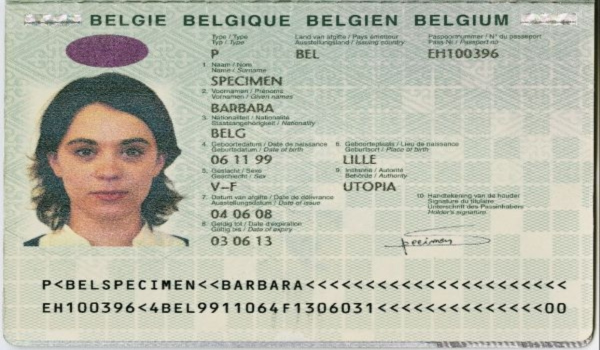

In [2]:
from datasets import load_dataset
dataset = load_dataset('sizhkhy/passports')

#Train & Test Splits
train = dataset['train']
eval = dataset['valid']

# ID2Label and Label2ID mapping useful for inference
# LayoutLMv3ForTokenClassification (the model we'll use later on) will simply output an integer index for a particular class (for each token)
id2label = {i:v for i, v in set(list(zip(flatten(train['labels']), flatten(train['label_string']))))}
label2id = {v:i for i, v in id2label.items()}

print("Dataset Dictionary:\n",dataset,'\n')
print('Features:\n')
print(dataset["train"].features,'\n','\nSample Image \n')
# Display sample image from dataset
sample = dataset["train"][0]
sample["image"]

* Define Processor
* Function to apply on entire dataset to encode inputs
* Create train and eval datasets
* Function to calculate Evaluation metrics used by the Trainer and it should take a named tuple as input, and return a dictionary as output

In [3]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def prepare_data(sample):
    images = sample['image']
    words = sample['words']
    boxes = sample['boxes']
    word_labels = sample['labels']
    # Pass through processor to get coresponding encodings
    encoding = processor(images, words, boxes=boxes, word_labels=word_labels, truncation=True, padding='max_length')
    return encoding

# Train and Evaluation datasets
train_dataset = train.map(prepare_data, batched=True, remove_columns=train.column_names,)
eval_dataset = eval.map(prepare_data, batched=True, remove_columns=eval.column_names)

# Set torch format
train_dataset.set_format('torch')

# Define Metric
metric = evaluate.load('seqeval')

# Function to calculate Evaluation metrics
return_entity_level_metrics = False
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    #Remove ignored index (special tokens)
    true_preds = [
            [id2label[p] for (p,l) in zip(pred,label) if l != -100]
                  for pred, label in zip(predictions,labels)
    ]
    true_labels = [
            [id2label[l] for (p,l) in zip(pred,label) if l!=-100]
                   for pred, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_preds, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        finial_results = {}
        for key, value in results.items():
            if isinstance(value,dict):
                for n,v in value.items():
                    finial_results[f'{key}_{n}']=v
            else:
                finial_results[key] = value
        return finial_results
    else:
        return {
            'precision':results['overall_precision'],
            'recall': results['overall_recall'],
            'f1':results['overall_f1'],
            'accuracy':results['overall_accuracy'],
        }


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

## **Define Model**
This is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [4]:
from transformers import LayoutLMv3ForTokenClassification
model = LayoutLMv3ForTokenClassification.from_pretrained(
                        "microsoft/layoutlmv3-base",
                        id2label = id2label,
                        label2id = label2id)

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Define **TrainingArguments and Trainer** where we define all hyperparameters rlated to model training, we will define basic parameters however there is huge amount of parameters to tweak.

In [5]:
from transformers import TrainingArguments, Trainer
from transformers.data.data_collator import default_data_collator

training_args = TrainingArguments(
                        output_dir="test",
                        max_steps=1000,
                        per_device_train_batch_size=2,
                        per_device_eval_batch_size=2,
                        learning_rate=1e-5,
                        evaluation_strategy='steps',
                        eval_steps=50,
                        load_best_model_at_end=True,
                        metric_for_best_model='f1')
trainer = Trainer(
        model=model,
        args = training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        tokenizer = processor,
        data_collator = default_data_collator,
        compute_metrics = compute_metrics)
print("\nModel Training: \n")
trainer.train()
print("\nModel Evaluation: \n")
trainer.evaluate()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



Model Training: 



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,No log,0.664929,0.000000,0.000000,0.000000,0.868794
100,No log,0.437722,0.000000,0.000000,0.000000,0.871158
150,No log,0.342225,0.456522,0.333333,0.385321,0.903073
200,No log,0.277943,0.721311,0.698413,0.709677,0.943262
250,No log,0.221284,0.616438,0.714286,0.661765,0.959811
300,No log,0.192176,0.656716,0.698413,0.676923,0.965721
350,No log,0.149637,0.723077,0.746032,0.734375,0.976359
400,No log,0.122946,0.718750,0.730159,0.724409,0.975177
450,No log,0.106460,0.712121,0.746032,0.728682,0.979905
500,0.283000,0.095184,0.727273,0.761905,0.744186,0.981087


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



Model Evaluation: 



/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.06491512805223465,
 'eval_precision': 0.7878787878787878,
 'eval_recall': 0.8253968253968254,
 'eval_f1': 0.8062015503875969,
 'eval_accuracy': 0.9846335697399528,
 'eval_runtime': 1.478,
 'eval_samples_per_second': 6.089,
 'eval_steps_per_second': 3.383,
 'epoch': 20.0}

# **Inference**

* Samples of the training dataset to show inference
* prepare it for the model using the processor
* Do a forward pass
* Model outputs logits of shape (batch_size, seq_len, num_labels)
* Take the highest score for each token
* Compare this to the ground truth
* Only compare predictions and labels at positions where the label isn't -100
* Get the bounding boxes of these (unnormalized)
* Display output

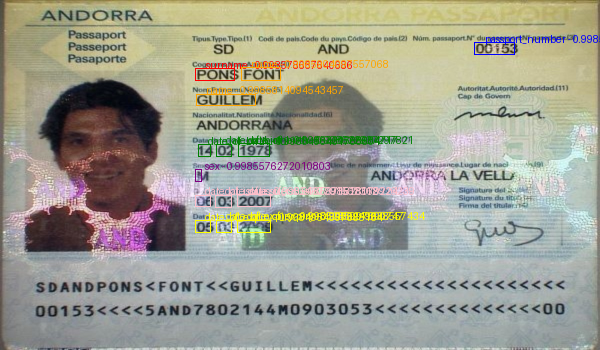

In [6]:

example = eval[0]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image = example["image"]
words = example["words"]
boxes = example["boxes"]
word_labels = example["labels"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt").to(device)
#for k,v in encoding.items():
#  print(k,v.shape)

with torch.no_grad():
  outputs = model(**encoding)

logits = outputs.logits

import torch.nn.functional as F
confs = F.softmax(logits, dim=-1).squeeze().tolist()

predictions = logits.argmax(-1).squeeze().tolist()
confs = [li[p] for (li,p) in zip(confs, predictions)]

labels = encoding.labels.squeeze().tolist()

def unnormalize_box(bbox, width, height):
      return [
          width * (bbox[0] / 1000),
          height * (bbox[1] / 1000),
          width * (bbox[2] / 1000),
          height * (bbox[3] / 1000),
      ]
token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

from PIL import ImageDraw, ImageFont
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label
print()
label2color = {'passport_number':'blue', 'date_of_birth':'green', 'name':'orange', 'fathers_name':'violet', 'surname': 'red','other':'black', 'sex':'purple', 'date_of_expiry': 'yellow', 'date_of_issue': 'pink'}
for prediction, box, conf in zip(true_predictions, true_boxes, confs):
    predicted_label = iob_to_label(prediction).lower()
    if predicted_label != 'other':
      draw.rectangle(box, outline=label2color[predicted_label])
      draw.text((box[0] + 10, box[1] - 10), text=f'{predicted_label} - {conf}', fill=label2color[predicted_label], font=font)

image
